In [1]:
import os

os.environ["L5KIT_DATA_FOLDER"] = "/home/us441/vlad/data/lyft"

import matplotlib.pyplot as plt

import numpy as np

from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset

from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data
from l5kit.visualization import draw_trajectory, TARGET_POINTS_COLOR
from l5kit.geometry import transform_points
from tqdm import tqdm
from collections import Counter
from l5kit.data import PERCEPTION_LABELS
from prettytable import PrettyTable

import os

from l5kit.visualization.visualizer.zarr_utils import zarr_to_visualizer_scene
from l5kit.visualization.visualizer.visualizer import visualize
from bokeh.io import output_notebook, show
from l5kit.data import MapAPI

In [2]:
# Dataset is assumed to be on the folder specified
# in the L5KIT_DATA_FOLDER environment variable

# get config
cfg = load_config_data("/home/us441/work/sync/l5kit/examples/visualisation/visualisation_config.yaml")
print(cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 10, 'future_num_frames': 50, 'step_time': 0.1, 'render_ego_history': True}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False, 'set_origin_to_bottom': True}, 'val_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16}}


In [3]:
dm = LocalDataManager()
dataset_path = dm.require(cfg["val_data_loader"]["key"])
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()
print(zarr_dataset)

rast = build_rasterizer(cfg, dm)
dataset = EgoDataset(cfg, zarr_dataset, rast)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


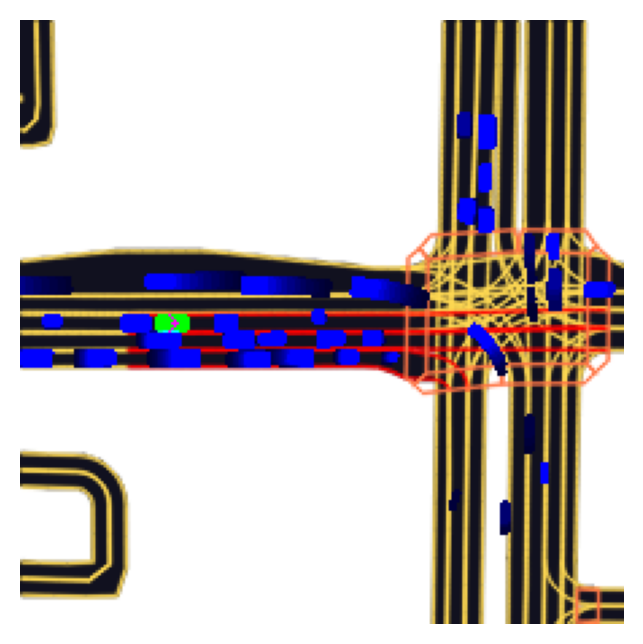

In [4]:
data = dataset[22000]

im = data["image"].transpose(1, 2, 0)
im = dataset.rasterizer.to_rgb(im)
target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])
draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=data["target_yaws"])

plt.figure(dpi=200)
plt.imshow(im)
plt.axis('off')

plt.show()

# Getting an unrolling of the future to use as context

In [5]:
import torch
from typing import Dict

class MockModel(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        
    def forward(self, data_batch: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        eval_dict = {
            "positions": torch.ones_like(data_batch['target_positions']) * 0,
            "yaws": torch.zeros_like(data_batch['target_yaws']) * 0.1,
        }
        return eval_dict

mock_model = MockModel()

In [6]:
num_scenes_to_unroll = 10
num_simulation_steps = 50

In [7]:
from l5kit.simulation.dataset import SimulationConfig
from l5kit.simulation.unroll import ClosedLoopSimulator

device = torch.device('cuda')

# ==== DEFINE CLOSED-LOOP SIMULATION
sim_cfg = SimulationConfig(use_ego_gt=False, use_agents_gt=True, disable_new_agents=True,
                           distance_th_far=500, distance_th_close=50, num_simulation_steps=num_simulation_steps,
                           start_frame_index=0, show_info=True)

sim_loop = ClosedLoopSimulator(sim_cfg, dataset, device, model_ego=mock_model, model_agents=None, keys_to_exclude=())

In [8]:
# ==== UNROLL
scenes_to_unroll = list(range(0, len(zarr_dataset.scenes), len(zarr_dataset.scenes)//num_scenes_to_unroll))
sim_outs = sim_loop.unroll(scenes_to_unroll)

/home/us441/work/sync/l5kit/l5kit/l5kit/data/zarr_dataset.py:213: RuntimeWarning: zarr dataset path should end with .zarr (for now). Open will fail for this dataset!
  dataset = ChunkedDataset("")
/home/us441/work/sync/l5kit/l5kit/l5kit/simulation/utils.py:107: RuntimeWarning: zarr dataset path should end with .zarr (for now). Open will fail for this dataset!
  new_dataset = ChunkedDataset("")


In [9]:
sim_outs[0].ego_ins_outs[0][1]

{'frame_index': 0,
 'image': array([[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]],
 
        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.      

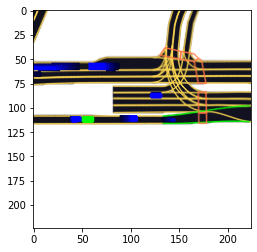

In [85]:
plt.imshow(rast.to_rgb(sim_outs[3].ego_ins_outs[49][1]['image'].transpose(1, 2, 0)))

In [86]:
context = [x[1]['image'] for x in sim_outs[0].ego_ins_outs]

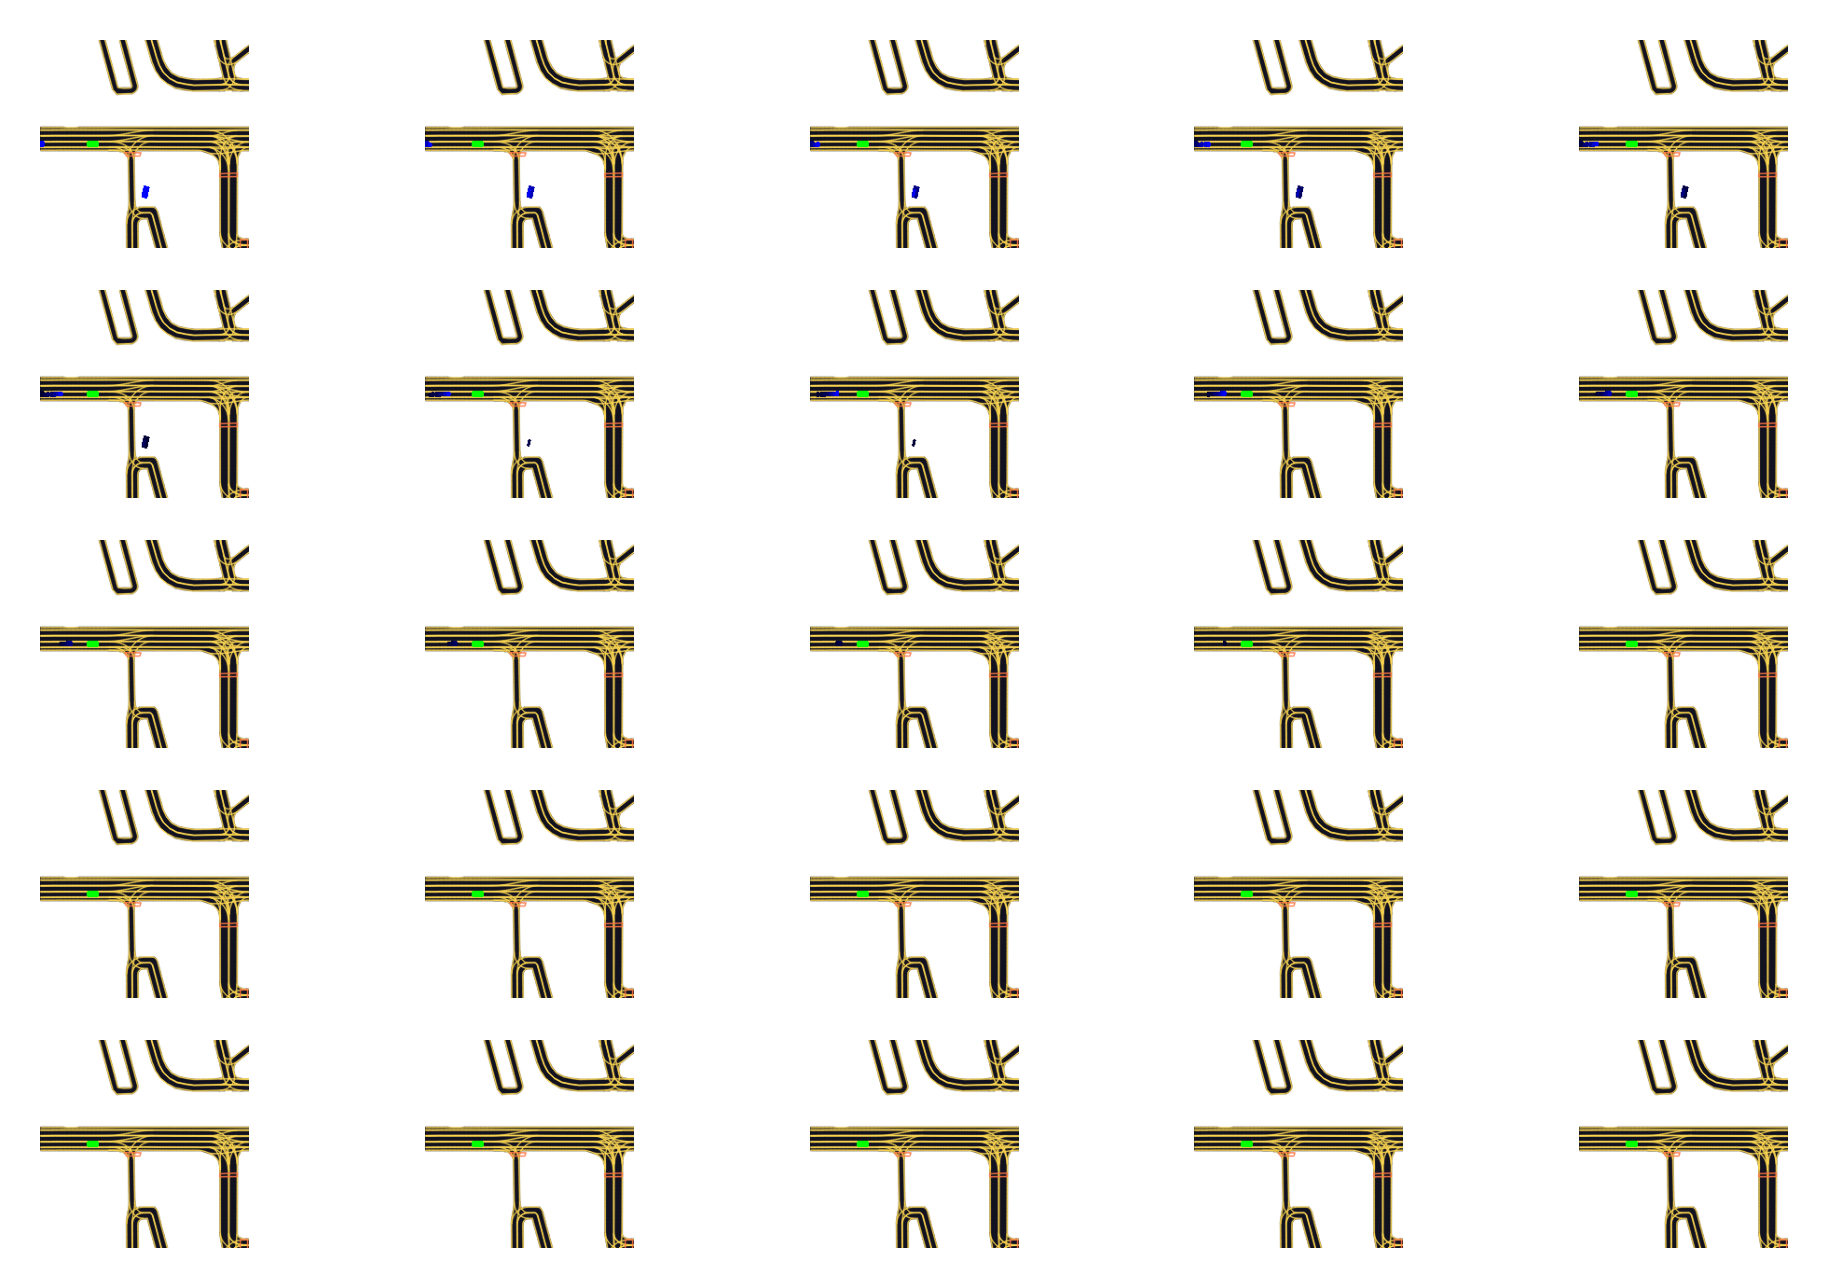

In [87]:
plt.figure(dpi=400)
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(rast.to_rgb(context[i * 2].transpose(1, 2, 0)))
    plt.axis('off')

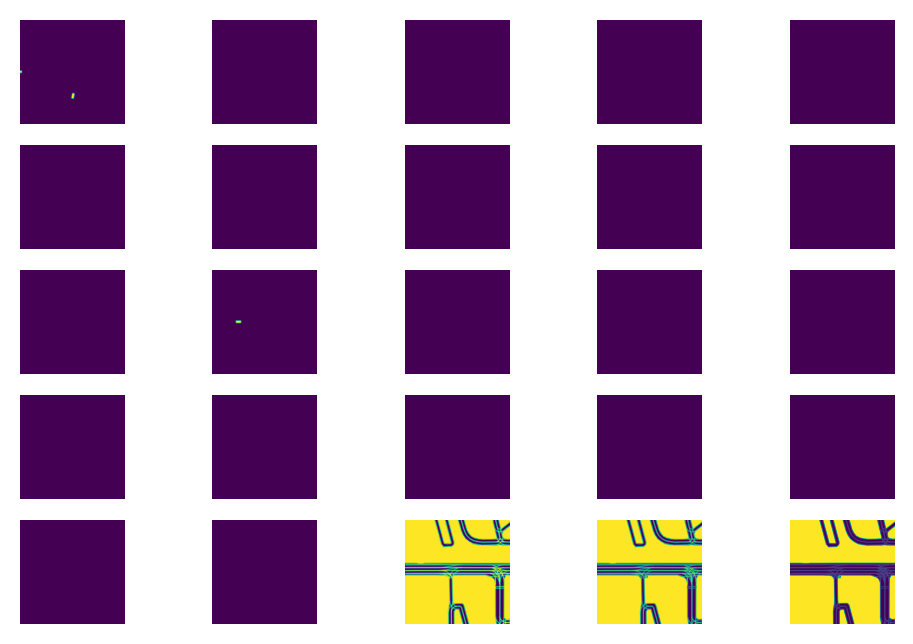

In [84]:
plt.figure(dpi=200)
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(context[0][i])
    plt.axis('off')

# Getting lane component from the raster 

In [56]:
context[0].shape

(25, 224, 224)

In [57]:
def get_lanes(img):
    joint = np.sum(img, axis=0) * 255 / 3
#     return joint
    d = 70
    return (joint > d) * (joint < 255 - d)

stacked = context[0][-3:]
lanes = get_lanes(stacked)
# plt.imshow(get_lanes(stacked))

In [58]:
lanes

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False,  True, False]])

(-0.5, 223.5, 223.5, -0.5)

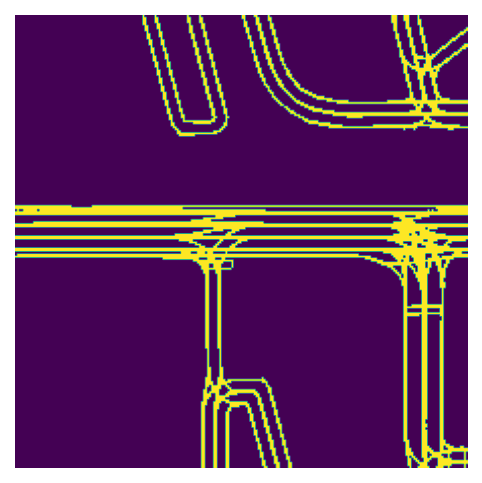

In [59]:
plt.figure(dpi=150)
plt.imshow(lanes)
plt.axis('off')

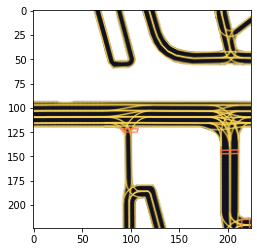

In [80]:
plt.imshow(stacked.transpose(1, 2, 0))

# Getting offroad info from the context

In [67]:
def get_offroad(img):
    joint = np.sum(img, axis=0) * 255 / 3
    d = 220
    return joint > d

stacked = context[0][-3:]
offroad = get_offroad(stacked)
# plt.imshow(get_lanes(stacked))

(-0.5, 223.5, 223.5, -0.5)

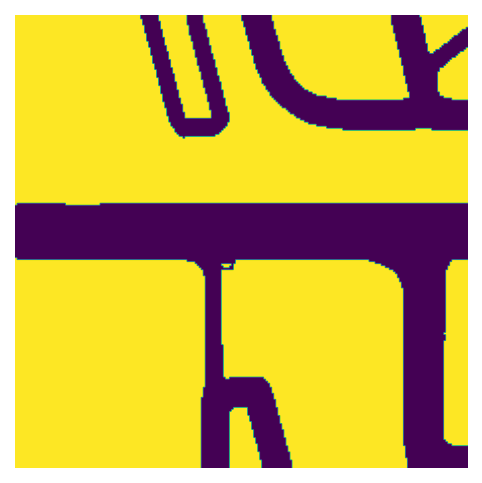

In [68]:
plt.figure(dpi=150)
plt.imshow(offroad)
plt.axis('off')

# Getting cars info from the context 

In [113]:
def get_cars(layers):
    """
    Some investigation into the box rasterizer revealed that the channels 
    in the context layers are split in equal halves (when we exclude the last three, which 
    are simply the road context).
    First half of (dim - 3)/2 is the other agents' history. From most recent to most remote.
    Second half of (dim - 3)/2 is the ego agent's history. From most recent to most remote.
    
    So, in order to render the ego car. We just get the most recent frames in the history for
    other vehicles. In other words, we just need the first channel lol.
    """
    return layers[0]
    
cars = get_cars(context[0])

(-0.5, 223.5, 223.5, -0.5)

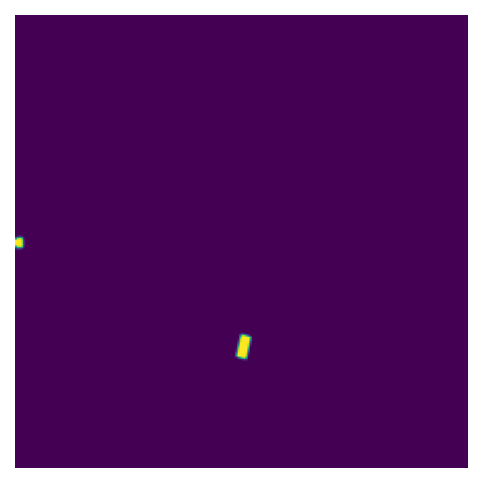

In [118]:
plt.figure(dpi=150)
plt.imshow(cars)
plt.axis('off')

# Creating a meshgrid to draw the mask

In [119]:
pixel_w = cfg['raster_params']['raster_size'][0]
pixel_h = cfg['raster_params']['raster_size'][1]

pixel_size_x = cfg['raster_params']['pixel_size'][0]
pixel_size_y = cfg['raster_params']['pixel_size'][1]

ego_center_x = cfg['raster_params']['ego_center'][0]
ego_center_y = cfg['raster_params']['ego_center'][1]

lo_x = -1 * ego_center_x * pixel_w * pixel_size_x
hi_x = (1 - ego_center_x) * pixel_w * pixel_size_x

lo_y = -1 * ego_center_y * pixel_h * pixel_size_y
hi_y = (1 - ego_center_y) * pixel_h * pixel_size_y

In [120]:
print(lo_x, hi_x)
print(lo_y, hi_y)

-28.0 84.0
-56.0 56.0


In [121]:
import torch

x = torch.linspace(lo_x, hi_x)
y = torch.linspace(lo_y, hi_y)

yy, xx = torch.meshgrid(y, x)

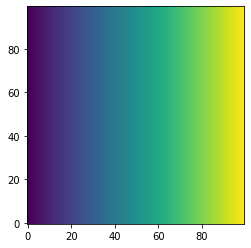

In [122]:
plt.imshow(xx, origin='lower')

In [123]:
car_l, car_w, car_h = data['extent']

In [124]:
data['extent']

array([4.87, 1.85, 1.8 ])

In [125]:
ff = (xx <= car_l / 2) * (xx >= -1 * car_l / 2) * (yy <= car_w / 2) * (yy >= -1 * car_w / 2)

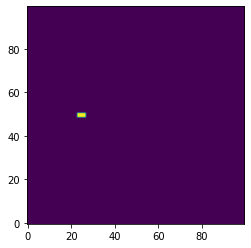

In [126]:
plt.imshow(ff, origin='lower')

In [128]:
data['image'].shape

(25, 224, 224)

# Simple kinematic model 

## Getting the initial state

In [153]:
sim_outs[0].ego_ins_outs[0].inputs['history_positions'].shape

(11, 2)

In [152]:
sim_outs[0].ego_ins_outs[0].inputs.keys()

dict_keys(['frame_index', 'image', 'target_positions', 'target_yaws', 'target_velocities', 'target_availabilities', 'history_positions', 'history_yaws', 'history_velocities', 'history_availabilities', 'world_to_image', 'raster_from_agent', 'raster_from_world', 'agent_from_world', 'world_from_agent', 'centroid', 'yaw', 'extent', 'history_extents', 'future_extents', 'curr_speed', 'scene_index', 'host_id', 'timestamp', 'track_id'])

In [163]:
def get_init_states(ego_ins_outs):
    speed = [ego_ins_outs[0].inputs['curr_speed']]
    orientation = ego_ins_outs[0].inputs['history_velocities'][0]
    position = ego_ins_outs[0].inputs['history_positions'][0]
    return torch.tensor(np.concatenate([position, orientation, speed], axis=0))

init_states = get_init_states(sim_outs[0].ego_ins_outs)

In [162]:
def predict_states(states, actions, timestep=0.1, noise=0.0):
    """
    Args:
        - states : tensor of shape [batch size, 4]
        - actions : tensor of shape [batch size, 2]
        - timestep : the time delta between two consecutive states
    """
    states = states.clone()
    actions = actions.clone()

    a = actions[:, 0]
    b = actions[:, 1].unsqueeze(1)

    positions = states[:, :2]

    speeds_norm = states[:, 4].unsqueeze(1)

    directions = states[:, 2:4]

    directions = directions / directions.norm(dim=1).unsqueeze(1)

    new_positions = positions + timestep * directions * speeds_norm

    ortho_directions = torch.stack(
        [directions[:, 1], -directions[:, 0]], axis=1
    )

    new_directions_unnormed = (
        directions + ortho_directions * b * speeds_norm * timestep
    )
    # + torch.tensor([1e-6, 0]).unsqueeze(0).to(directions.device)

    new_directions = new_directions_unnormed / (
        torch.clamp(
            new_directions_unnormed.norm(dim=1).view(positions.shape[0], 1),
            min=1e-8,
            max=1e6,
        )
    )

    new_speeds_norm = speeds_norm + a.unsqueeze(1) * timestep

    new_states = torch.cat([new_positions, new_directions, new_speeds_norm], 1)

    if noise > 0:
        new_states += torch.randn_like(new_states) * noise

    return new_states

In [164]:
actions = torch.tensor([1, 1])

In [167]:
predict_states(init_states.unsqueeze(0), actions.unsqueeze(0))

tensor([[ 4.5475e-13,  0.0000e+00,  1.0000e+00, -2.2737e-13,  1.0000e-01]])